In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Initialize data
x1 = np.array([2,3,5,7, 11,12,14,16,18,  17,20,22,23,26,27])
x2 = np.array([15,17,18,13, 7,4,8,4,6,  16,12,15,20,16,12])
X = pd.DataFrame(data=(x1,x2))

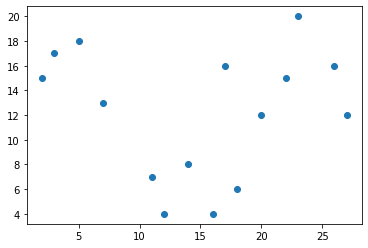

In [3]:
plt.scatter(x1, x2)

In [4]:
def generate_random_clusters(X, k):
    clusters = np.array(np.array([
        np.random.randint(X.iloc[i,:].min(), X.iloc[i,:].max(), k) for i in range(X.shape[0])
        ])).T
    return clusters

def check_all_clusters_used(k, classes):
    for i in range(k):
        if i not in classes:
            return False
    return True

def measure_distances(points, clusters):
    return np.array([np.sum((X.values.T - cluster) ** 2, axis=1) for cluster in clusters])

def predict(clusters, data):
    distances =  measure_distances(X.values.T, clusters)
    classes = distances.argmin(axis=0)
    return classes

In [5]:
def kmeans(X, k=5, max_iter=300, convergence_threshold=5):
    # Keep track of each clustering epoch & its variation
    variations = np.empty((0,), float)
    clusters_tries = np.empty((0, k, X.shape[0]), float)
    
    # Generate random K clusters
    current_clusters = generate_random_clusters(X, k)
    
    same_variation_counter = 0
    clusters_randomly_generated_counter = 1
    
    # Run algorithm until max_iter or stopping condition
    for i in range(max_iter):
        distances = measure_distances(X.values.T, current_clusters)
        classes = distances.argmin(axis=0)

        # If any cluster has 0 data points, regenarate random clusters
        if(not check_all_clusters_used(k, classes)):
            current_clusters = generate_random_clusters(X, k)
            clusters_randomly_generated_counter += 1
            continue

        variation = np.unique(distances.argmin(axis=0), return_counts=True)[1].var() 
        new_clusters = np.array([X.values.T[classes == i].mean(axis=0) for i in range(current_clusters.shape[0])])

        # If variation is ZERO but there exist new positions for clusters,
        # then it's FAKE minimum variation, set it to inf to ignore it later
        if variation == 0 and (current_clusters != new_clusters).all():
            variation = float("inf")

        # Reposition clusters
        current_clusters = new_clusters
        clusters_tries = np.concatenate((clusters_tries, np.array([current_clusters])))
        variations = np.append(variations, variation)

        # If current variation is the minimum variation of all tries
        # increment same_variation_counter
        if len(variations) > 2 and variations.min() == variation:
            same_variation_counter += 1

        # If same_variation_counter crossed convergence threshold
        # regenerate random clusters, in order to find the
        # global minimum variation
        if same_variation_counter > convergence_threshold:
            current_clusters =  generate_random_clusters(X, k)
            clusters_randomly_generated_counter += 1
            same_variation_counter = 0

        # If clusters are generated for (n) times
        # it means the same variation has occured for (n)^2 times
        # now we can stop optimization
        if clusters_randomly_generated_counter == convergence_threshold:
            break

    # Find minimum variation, searching from the end of the array
    best_variation_index = np.where(variations == variations.min())[0][-1]
    best_clusters = clusters_tries[best_variation_index]
    return best_clusters

In [6]:
k = 3
best_clusters = kmeans(X, k)
y_pred = predict(best_clusters, X)

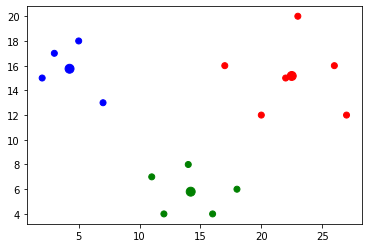

In [7]:
colors = np.array(['red', 'green', 'blue'])
plt.scatter(x1,x2, color=colors[y_pred])
plt.scatter(best_clusters[:,0], best_clusters[:,1], color=colors, s=80)